<a href="https://colab.research.google.com/github/AdriMA3/MECA/blob/main/tareagrupal2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exercise 1
You will make two maps:

1. Plot your country as the background. Use cx to plot some points (the cities, airports, etc.) below the centroid.
2. Plot your country as the background. Select with cx all the first administrative divisions above the centroid. Then, use clip to show some lines (rivers, railroads, etc) that cross those divisions.

In [1]:
!pip install geopandas

In [2]:
!pip install fiona

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 61.2 MB/s eta 0:00:00


In [9]:
import geopandas as gpd
from fiona import listlayers
countries=gpd.read_file("https://github.com/AdriMA3/introgeodf/raw/refs/heads/main/maps/World_Countries/World_Countries.shp")
cities=gpd.read_file("https://github.com/AdriMA3/introgeodf/raw/refs/heads/main/maps/World_Cities/World_Cities.shp")
regiones=gpd.read_file("https://github.com/AdriMA3/introgeodf/raw/refs/heads/main/maps/Regiones/Regional.shp")
airports=gpd.read_file("https://github.com/AdriMA3/introgeodf/raw/refs/heads/main/data/chile-airports.csv")
ferrovias=gpd.read_file("https://github.com/AdriMA3/introgeodf/raw/refs/heads/main/maps/Red_Ferroviaria/Red_ferroviaria.shp")

In [10]:
chile=countries[countries.COUNTRY=="Chile"]
chile_5361=chile.to_crs(5361)


In [11]:
#asignaremos un crs conocido para luego poroyectar
# Asegurar que ambos estén en el mismo CRS antes del clip
ferrovias_aligned = ferrovias.to_crs(chile.crs)

# Realizar el clip
ferroviasChile_clipped = gpd.clip(ferrovias_aligned, chile)

# Luego proyectar al CRS deseado (por ejemplo EPSG:5361)
ferrovias_chile_5361 = ferroviasChile_clipped.to_crs(5361)

In [16]:
airports=gpd.GeoDataFrame(data=airports.copy(),
                 geometry=gpd.points_from_xy(airports.longitude_deg,
                                             airports.latitude_deg),
                 crs=chile.crs.to_epsg())
airports_5361=airports.to_crs(5361)

In [17]:
regiones.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [22]:
regiones.crs = "EPSG:3857"

In [23]:
regiones=regiones.to_crs(5361)

In [24]:
chile_centroid=chile.to_crs(5361).centroid

In [25]:
cities_chile_5361=cities[cities.COUNTRY=='Chile'].to_crs(5361)

In [26]:
#centroide
centroidX,centroidY=chile_5361.centroid.x.values[0],chile_5361.centroid.y.values[0]
#the arriba
regiones_A=regiones.cx[:,centroidY:]
cities_chile_5361_A=cities_chile_5361.cx[:,centroidY:]
airports_5361_A=airports_5361.cx[:,centroidY:]

#the abajo
regiones_B=regiones.cx[:,:centroidY]
cities_chile_5361_B=cities_chile_5361.cx[:,:centroidY]
airports_5361_B=airports_5361.cx[:,:centroidY]


<Axes: >

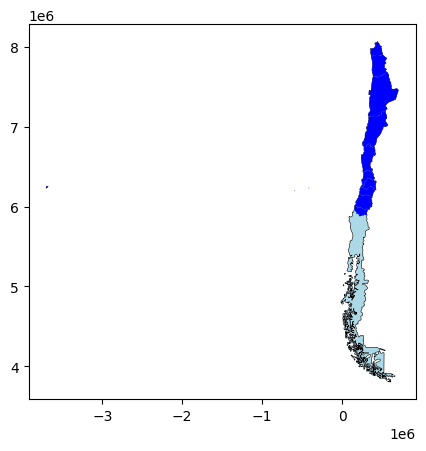

In [37]:
base=chile_5361.plot(facecolor='lightblue',edgecolor='black',linewidth=0.4,figsize=(5,5))
regiones_A.plot(marker='.',color='blue',markersize=13,ax=base)


<Axes: >

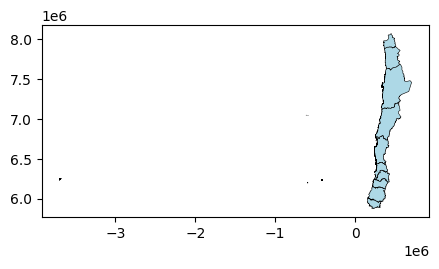

In [43]:
regiones_A.plot(facecolor='lightblue',edgecolor='black',linewidth=0.4,figsize=(5,5))

<Axes: >

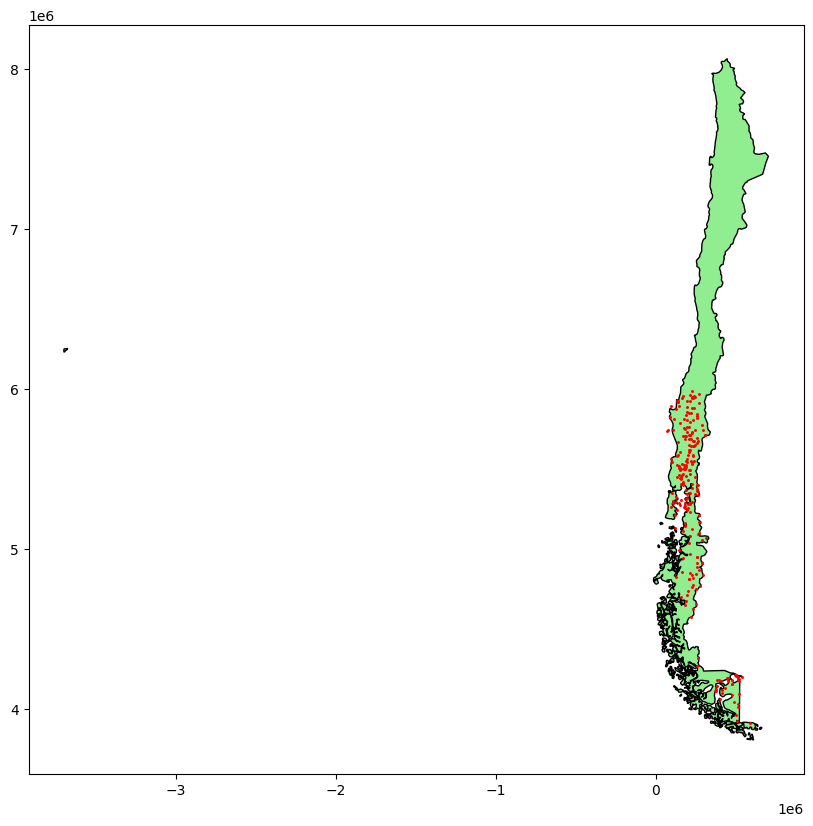

In [39]:
base = chile_5361.plot(facecolor='lightgreen', edgecolor='black', figsize=(10, 10))
airports_5361_B.plot(marker='.', color='red', markersize=5, ax=base)

<Axes: >

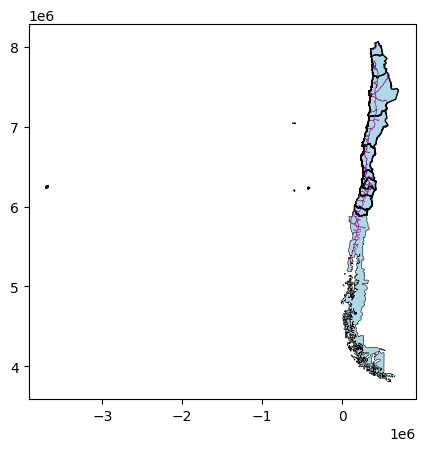

In [40]:
base=chile_5361.plot(facecolor='lightblue',edgecolor='black',linewidth=0.4,figsize=(5,5))
regiones_A.plot(facecolor='lightblue',edgecolor='black',linewidth=1,ax=base)
ferrovias_chile_5361.plot(edgecolor="purple",linewidth=0.5,ax=base)

Exercise 2

1.Create some subset of polygons with your country data at the municipal (or similar level). Use Unary UNION with those polygons, and create a geoDF with the result.
2.Dissolve your municipalities by another higher level administrative level. Plot the result.
3.If possible, color some areas of your country by aggregating; if not, plot the "median" values in the indicators map.

In [44]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.ops import unary_union


In [45]:
link_comunas = "https://github.com/AdriMA3/introgeodf/raw/refs/heads/main/maps/Comunas/comunas.shp"
comunas = gpd.read_file(link_comunas)

In [46]:
# Regiones
link_regiones = "https://github.com/AdriMA3/introgeodf/raw/refs/heads/main/maps/Regiones/Regional.shp"
regiones = gpd.read_file(link_regiones)

In [48]:
comunas = comunas.to_crs(epsg=5361)
regiones = regiones.to_crs(epsg=5361)

In [61]:
union_total = comunas.unary_union

# Check if the union results in a MultiPolygon and select the largest part if it does
from shapely.geometry import MultiPolygon, Polygon

if isinstance(union_total, MultiPolygon):
    # Find the largest polygon in the MultiPolygon
    continente = max(union_total.geoms, key=lambda p: p.area)
elif isinstance(union_total, Polygon):
    continente = union_total
else:
    # Handle cases where the union is not a Polygon or MultiPolygon
    print("The result of the unary union is not a Polygon or MultiPolygon.")
    continente = None

# If continente is not None, proceed with intersection
if continente:
    comunas_cont = comunas[comunas.intersects(continente)]
    regiones_cont = regiones[regiones.intersects(continente)]

<Axes: >

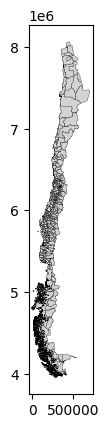

In [63]:
comunas_cont.plot(facecolor='lightgrey', edgecolor='black',linewidth=0.2)

In [69]:
comunas_cont.head()

,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia,geometry
0,48,170038.624165,16,8,6204,6,9.685774e+08,206184.271675,Región del Libertador Bernardo O'Higgins,Marchigüe,Cardenal Caro,"POLYGON ((241952.062 6211313.004, 242028.141 6..."
1,29,125730.104795,15,8,6102,6,4.157446e+08,151911.576827,Región del Libertador Bernardo O'Higgins,Codegua,Cachapoal,"POLYGON ((374986.571 6242271.907, 375032.593 6..."
2,30,63026.084422,15,8,6103,6,1.448565e+08,76355.326122,Región del Libertador Bernardo O'Higgins,Coinco,Cachapoal,"POLYGON ((324962.762 6209928.875, 324959.444 6..."
3,31,89840.903562,15,8,6104,6,3.256572e+08,108874.623150,Región del Libertador Bernardo O'Higgins,Coltauco,Cachapoal,"POLYGON ((313363.258 6217082.384, 313522.191 6..."
4,78,122626.493264,23,11,9121,9,6.990727e+08,156680.410681,Región de La Araucanía,Cholchol,Cautín,"POLYGON ((154573.937 5734741.503, 154662.829 5..."
